In [4]:
# Import libraries
from dotenv import load_dotenv
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
from sqlalchemy import create_engine

In [5]:
# Load environment variables
load_dotenv()
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_name = os.getenv('DB_NAME')

In [6]:
# Connect to the Stack Overflow database
conn = psycopg2.connect(
    host=db_host,
    database=db_name,
    user=db_user,
    password=db_password
)

In [7]:
# With the env variables loaded we can insert them into the engine connection string.
engine = create_engine(f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}/{db_name}")
connection = engine.connect()

In [8]:

# Define HEART metrics for Stack Overflow
heart_metrics = {
    'Happiness': 'Measure of user satisfaction and happiness with the Questions & Answers product.',
    'Engagement': 'Measure of user interaction and activity on the platform.',
    'Adoption': 'Measure of user acquisition and growth of Stack Overflow user base.',
    'Retention': 'Measure of user retention and continued usage of the platform over time.',
    'Task Success': 'Measure of user ability to accomplish their goals and tasks effectively on Stack Overflow.'
}

# Stack Overflow User Data Analysis

This project aims to analyse the quality of the Questions and Answers UX with a view to reporting back to the Product Manager of the Q&A team. We will do so by analysing various UX metrics as described in the HEART metrics system which was first developed by Google. 

The HEART system describes 5 key areas that are important to providing a positive user experience. These five key metrics are:

In [9]:
for key, desc in heart_metrics.items():
    print(f"{key}: {desc}")

Happiness: Measure of user satisfaction and happiness with the Questions & Answers product.
Engagement: Measure of user interaction and activity on the platform.
Adoption: Measure of user acquisition and growth of Stack Overflow user base.
Retention: Measure of user retention and continued usage of the platform over time.
Task Success: Measure of user ability to accomplish their goals and tasks effectively on Stack Overflow.


*Note: SQL queries in this analysis use a fixed date of 2023-11-17 wherever there is a requirement for the current date. This is to enable accurate conclusions to be drawn without encountering issues caused by user activity changing over time.*

## Happiness
The happiness metric is defined as:
> Happiness: Measure of user satisfaction and happiness with the Questions & Answers product.

Currently we have access to the following tables in the Stack Overflow public database dump:
- Users
- Posts
- Comments
- Votes
- Tags

With the data that we have available it is not possible to analyse this metric. We do not currently possess any data that reflects the user's satisfaction with the product. In order to address this and be able to assess the happiness metric down the line, we should endeavor to conduct a survey of our users. This survey could be conducted during real time use of the site by asking users to answer a question or two at various times or through a more indepth survey of our most engaged users. 

# Engagement

The engagement metric is defined as:
>Engagement: Measure of user interaction and activity on the platform.

In order to conduct this analysis we will need to decide what to count as an 'engaged' user. For example, we could say that a user logging in to their account would be considered engaged. Or perhaps engaged means to have posted a question? What about posting a comment? Or an answer?

For the purposes of this analysis we will define an engaged user as a user account that has created a post (either question or answer) in the last year. Posting questions and answering them is a core feature of Stack Overflow and will therefore be the focus of our determination as to whether or not a user is engaged with the product. Other minor features, such as votes and comments, may provide interesting results from analysis but engagement with these features is less meaningful in terms of the main focus of the website. 

This analysis will focus on the engagement of user accounts that have been active in the last year. The decision to focus only on recently active accounts has been made to conserve time and computing resources as these accounts will provide the greatest insight into decisions made affecting SO's future. It is also fair to say that an account that has not been active for a year or more cannot be considered currently engaged with the product. 

First we must extract the necessary data from the database. We will gather the records of all user accounts that have been active within the last year and any posts those accounts have made. 

In [10]:
engagement_query = """SELECT users.id AS user_id, users.display_name AS display_name,
        posts.id AS post_id, posts.title AS post_title
FROM (
    SELECT id, display_name
    FROM users
    WHERE last_access_date >= DATE '2023-11-17' - interval '1 year'
) users
LEFT JOIN posts ON users.id = posts.owner_user_id
"""

# Use chunking to read data in smaller portions
chunk_size = 10000  # Experiment with different chunk sizes
chunks = pd.read_sql_query(engagement_query, connection, chunksize=chunk_size)

# Process and append the chunks to a DataFrame
engagement_df = pd.concat(chunks)

engagement_df

/var/folders/yr/3n5v6lks7kdf1dzxf43l8mlw0000gp/T/ipykernel_6650/409509095.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  engagement_df = pd.concat(chunks)


,user_id,display_name,post_id,post_title
0,505088,David Heffernan,19402741.0,None
1,548225,anubhava,19402752.0,None
2,1048093,wemu,19402787.0,None
3,19068,Quentin,19402790.0,None
4,17034,Hans Passant,19402802.0,None
...,...,...,...,...
424,17699039,SebastianTritsch,NaN,None
425,17466324,Jayden Chou,NaN,None
426,5662752,nakanara,NaN,None
427,20129075,usama440,NaN,None


Next we will conduct a quick calculation to see how many accounts have or have not created at least one post and compare the results. 

In [11]:
engaged_users_count = engagement_df[engagement_df['post_id'].notnull()]['user_id'].nunique()
disengaged_users_count = engagement_df[engagement_df['post_id'].isnull()]['user_id'].nunique()

print(f"Number of users with at least one post: {engaged_users_count}")
print(f"Number of users without a post: {disengaged_users_count}")

Number of users with at least one post: 1332831
Number of users without a post: 1872167


This initial analysis shows that of the 3,204,998 accounts that have been accessed within the last year approximately 42% of them have created a post, either a question or answer, on Stack Overflow. 

Next, we will examine the engaged users more closely and determine some statistical values such as the mean number of posts per account, the range of number of posts and the distribution of posts across accounts. 

We will also examine the age of the account vs the number of posts to determine whether or not there is any correlation. 

First, we'll remove any accounts that have not posted from our dataframe as this will not be relevant to the next stages of our analysis. 

In [12]:
filtered_engagement_df = engagement_df[engagement_df['post_id'].notnull()]
filtered_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34598262 entries, 0 to 1130
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   user_id       int64  
 1   display_name  object 
 2   post_id       float64
 3   post_title    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.3+ GB


By comparing the number of posts to the number of unique user id's we can determine the mean number of posts per user. 

In [13]:
posts_count = len(filtered_engagement_df.index)
user_count = filtered_engagement_df['user_id'].nunique()

print(f"There are {posts_count} total posts and {user_count} unique users. This gives a mean of {posts_count/user_count} posts per user.")

There are 34598262 total posts and 1332831 unique users. This gives a mean of 25.95847635596711 posts per user.


Next we will count how many posts each user has made and plot them on a graph to examine the distribution. 

In [14]:
post_counts = filtered_engagement_df.groupby('user_id').size().reset_index(name='post_count')

          user_id  post_count
0               1         142
1               2          11
2               3          48
3               4         213
4               5         321
...           ...         ...
1332826  20686053           2
1332827  20686056           1
1332828  20686063           1
1332829  20686066           1
1332830  20686106           1

[1332831 rows x 2 columns]


In [61]:
post_count_frequency = {}

for row in post_counts['post_count']:
    if row in post_count_frequency:
        post_count_frequency[row] += 1
    else:
        post_count_frequency[row] = 1

post_count_frequency = dict(sorted(post_count_frequency.items()))

freq_series = pd.Series(post_count_frequency)
freq_df = pd.DataFrame(freq_series)
freq_df

,0
1,329150
2,160027
3,102343
4,75820
5,59402
...,...
29653,1
31125,1
35588,1
36739,1


##*TODO: Plot graph of post count freq's to see trend*

# Adoption

The adoption metric is defined as:
> Adoption: Measure of user acquisition and growth of Stack Overflow user base.

In order to analyse this metric we will look at the number of new user accounts created per month. 

In [16]:
adoption_query = """
SELECT TO_CHAR(creation_date, 'YYYY-MM') AS YearMonth,
    COUNT(*) AS Count 
FROM users 
GROUP BY YearMonth
ORDER BY YearMonth;
"""
adoption_df = pd.read_sql(adoption_query, connection)
adoption_df

,yearmonth,count
0,2008-07,9
1,2008-08,2806
2,2008-09,9643
3,2008-10,3544
4,2008-11,2857
...,...,...
172,2022-11,264690
173,2022-12,249281
174,2023-01,217014
175,2023-02,184360


Now that we have counted the number of accounts created each month we can plot this as a bar chart in order to interpret the data visually. 

/var/folders/yr/3n5v6lks7kdf1dzxf43l8mlw0000gp/T/ipykernel_6650/3547781227.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(year_month_pattern)


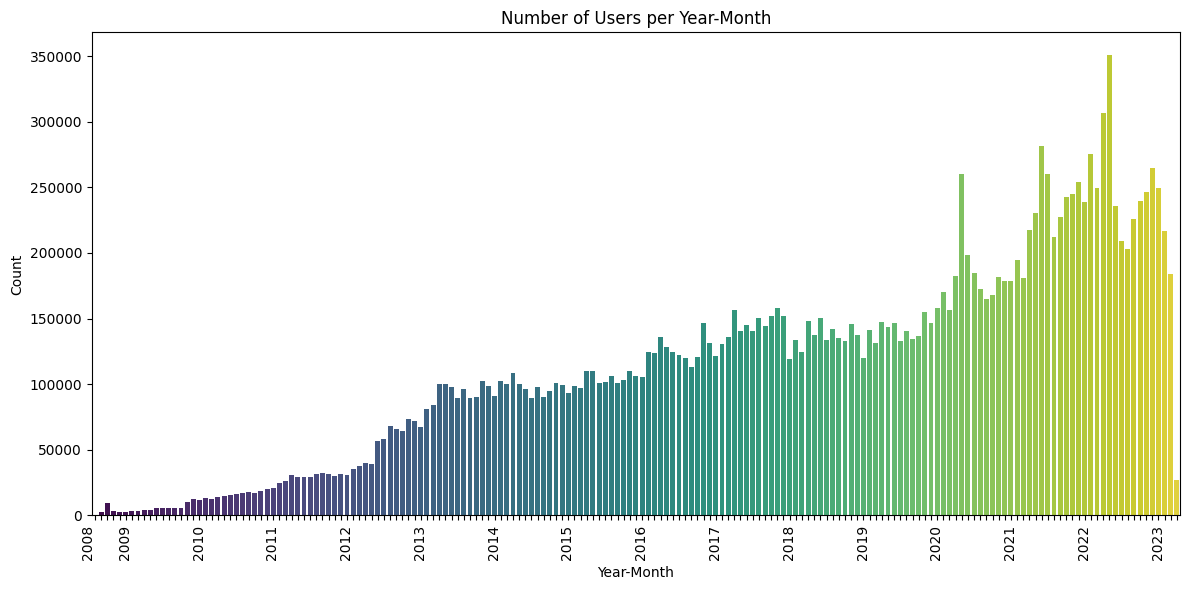

In [17]:
# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="yearmonth", y="count", data=adoption_df, hue="yearmonth", palette="viridis")
plt.title("Number of Users per Year-Month")
plt.xlabel("Year-Month")
plt.ylabel("Count")
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for readability

# Get unique years for dropdown options
unique_years = adoption_df['yearmonth'].str.split('-').str[0].unique()

# Create a list with the desired pattern
year_month_pattern = []

for year in unique_years:
    year_month_pattern.append(year)
    year_month_pattern.extend([' '] * (adoption_df['yearmonth'].str.startswith(year).sum() - 1))

ax.set_xticklabels(year_month_pattern)

# Show the plot
plt.tight_layout()
plt.show()

From the bar chart we can see a clear upward trend in the number of new user accounts created over time. This would suggest that the popularity of Stack Overflow has increased over time and will likely continue to do so. 

There are spikes in account creations in the early-mid parts of 2020, 2021, 2022 and to a lesser extent 2023. Without further data it is not possible to conclude what caused these spikes. However, collaboration with other teams i.e. marketing, may reveal insights as to their cause. 

The next chart allows us to view one year at a time for further analysis. 

Dropdown(description='Select Year:', options=('2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', …

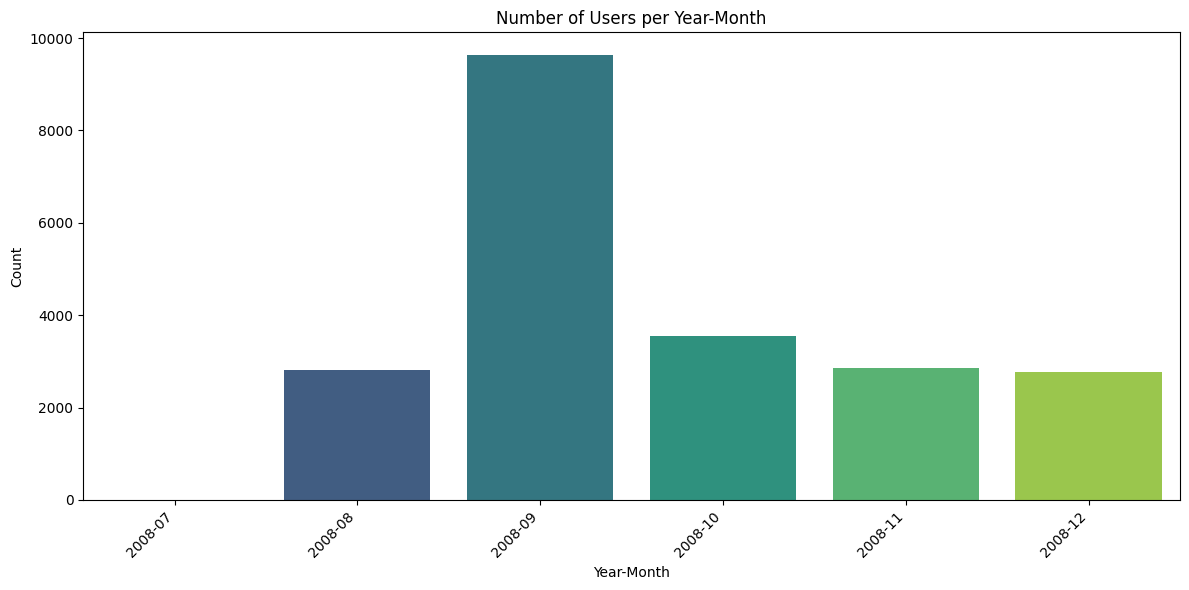

In [18]:
def plot_interactive_chart(selected_year):
    filtered_df = adoption_df[adoption_df['yearmonth'].str.startswith(str(selected_year))]
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x="yearmonth", y="count", data=filtered_df, hue="yearmonth", palette="viridis")
    plt.title("Number of Users per Year-Month")
    plt.xlabel("Year-Month")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Get unique years for dropdown options
unique_years = adoption_df['yearmonth'].str.split('-').str[0].unique()

# Create a dropdown for year selection
year_dropdown = widgets.Dropdown(
    options=unique_years,
    description='Select Year:',
    disabled=False,
)

# Display Year Dropdown selector
display(year_dropdown)

# Define the function to update the plot based on the selected year
def update_plot(change):
    clear_output(wait=True)  # Clear the previous chart only
    display(year_dropdown)  # Redisplay the dropdown
    plot_interactive_chart(change.new)

# Connect the dropdown to the update function
year_dropdown.observe(update_plot, names='value')

# Display the dropdown and initial plot
plot_interactive_chart(unique_years[0]) 

## Retention
The retention metric is defined as:
>Retention: Measure of user retention and continued usage of the platform over time.

I will determine a users retention by comparing their account creation_date with their last_access_date. I will then group the user into one of the below categories, based on the time delta between their creation and last access. For example, if a user creates an account and the last_access_date is less than a week later they will come under the "Retained for less than 1 week" category i.e. the account was last accessed within a week of it's creation and therefore the user was 'retained' for less than a week. Likewise an account with a last_access_date that is more than 1 year and less than 2 years after creation will be classed as "Retained for between 1 and 2 years" i.e. the user was 'retained' for between 1-2 years.

In order to prevent a skew in the data caused by recently created accounts, I will only include accounts that are more than 1 year old in this analysis. I will also discard any accounts where there is no difference between the two dates. 

- Retained for less than 1 week
- Retained for between 1 week and 1 month
- Retained for between 1 and 3 months
- Retained for between 3 and 6 months
- Retained for between 6 months and 1 year
- Retained for between 1 and 2 years
- Retained for between 2 and 3 years
- etc.

In [19]:
retention_query = "SELECT creation_date, last_access_date " \
        "FROM users " \
        "WHERE creation_date <= DATE '2023-11-17' - interval '1 year' " \
        "AND last_access_date > creation_date "

# Fetch only the required data from the database
retention_df = pd.read_sql(retention_query, connection)

# Convert columns to datetime in pandas
retention_df['creation_date'] = pd.to_datetime(retention_df['creation_date'])
retention_df['last_access_date'] = pd.to_datetime(retention_df['last_access_date'])

# Calculate time difference in pandas
retention_df['time_delta'] = retention_df['last_access_date'] - retention_df['creation_date']

retention_df


,creation_date,last_access_date,time_delta
0,2022-03-24 14:50:11.607,2023-03-03 15:26:56.733,344 days 00:36:45.126000
1,2008-07-31 00:00:00.000,2008-08-26 00:16:53.810,26 days 00:16:53.810000
2,2008-07-31 14:22:31.287,2023-01-27 20:51:56.877,5293 days 06:29:25.590000
3,2008-07-31 14:22:31.287,2023-03-03 16:55:29.527,5328 days 02:32:58.240000
4,2008-07-31 14:22:31.287,2022-12-14 04:49:01.427,5248 days 14:26:30.140000
...,...,...,...
16163142,2022-08-12 01:56:38.670,2023-03-03 21:23:31.160,203 days 19:26:52.490000
16163143,2022-03-18 09:26:13.757,2023-02-25 11:23:04.470,344 days 01:56:50.713000
16163144,2020-12-02 14:48:21.980,2023-03-04 15:32:49.877,822 days 00:44:27.897000
16163145,2011-02-05 09:50:17.437,2023-03-03 04:30:53.453,4408 days 18:40:36.016000


Now that we have extracted the necessary data from the database and calculated the time delta between creation and last activation we can group each entry into the appropriate category. This will enable use to plot each category in order to visualise the data.

In [20]:
# Calculate days, months, and years from time_delta
days = retention_df['time_delta'].dt.days
months = retention_df['time_delta'] // pd.Timedelta(days=30)
years = retention_df['time_delta'] // pd.Timedelta(days=365)

# Initialize retention dictionary
retention = {
    "1 week": (days < 7).sum(),
    "1 month": ((days >= 7) & (months < 1)).sum(),
    "3 months": ((months >= 1) & (months < 3)).sum(),
    "6 months": ((months >= 3) & (months < 6)).sum(),
    "1 year": ((months >= 6) & (years < 1)).sum(),
    "2 years": ((years >= 1) & (years < 2)).sum(),
    "3 years": ((years >= 2) & (years < 3)).sum(),
    "4 years": ((years >= 3) & (years < 4)).sum(),
    "5 years": ((years >= 4) & (years < 5)).sum(),
    "6 years": ((years >= 5) & (years < 6)).sum(),
    "7 years": ((years >= 6) & (years < 7)).sum(),
    "8 years": ((years >= 7) & (years < 8)).sum(),
    "9 years": ((years >= 8) & (years < 9)).sum(),
    "10 years": ((years >= 9) & (years < 10)).sum(),
    "11 years": ((years >= 10)  & (years < 11)).sum(),
    "12 years": ((years >= 11)  & (years < 12)).sum(),
    "13 years": ((years >= 12)  & (years < 13)).sum(),
    "14 years": ((years >= 13)  & (years < 14)).sum(),
    "15 years": ((years >= 14)  & (years < 15)).sum()
}

print("Here is the breakdown of user retention by timedelta:")
for key, value in retention.items():
    print(f"{key}: {value}")

Here is the breakdown of user retention by timedelta:
1 week: 2767388
1 month: 1658213
3 months: 2075750
6 months: 1674095
1 year: 1786157
2 years: 1761038
3 years: 1060770
4 years: 747349
5 years: 597758
6 years: 495869
7 years: 397745
8 years: 321450
9 years: 260622
10 years: 218317
11 years: 151502
12 years: 94498
13 years: 52495
14 years: 30494
15 years: 11637


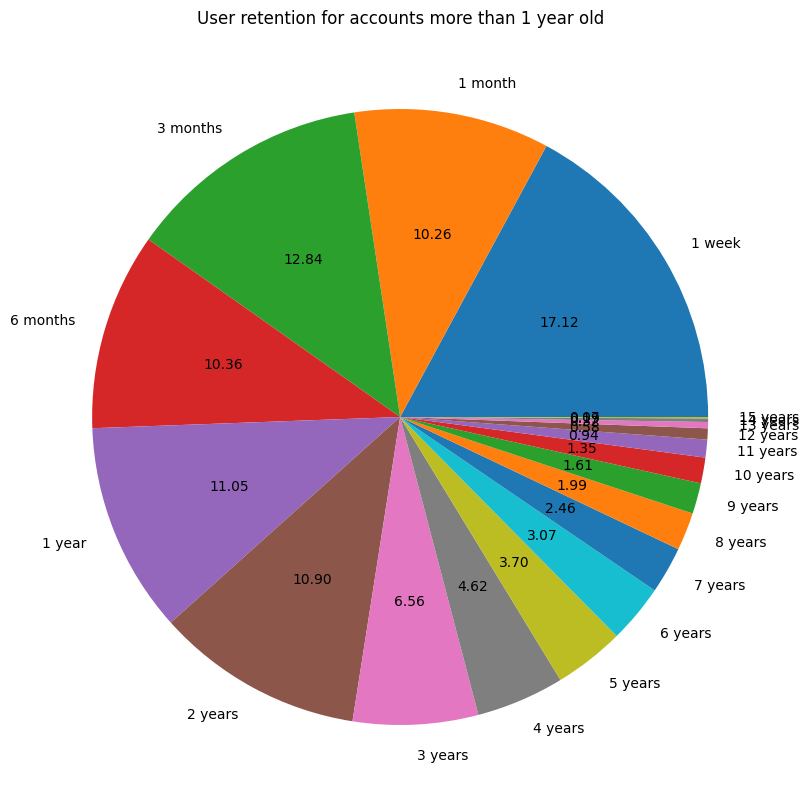

In [21]:
plt.figure(figsize=(10,10))
plt.pie(retention.values(), labels=retention.keys(), autopct='%.2f')
plt.title("User retention for accounts more than 1 year old")
plt.show()

From this chart we can see that the majority of user accounts are retained for less than 6 months with a total of 50.53% of user accounts in the database not being accessed more than 6 months after being created. It is also worth noting that 61.59% of accounts are abandoned within 1 year of creation. 

Whilst there is a steep decline in retained accounts in the first year, and a steady decline in retained accounts from year to year, the rate of loss does seem to decrease. I will plot this to see if a rate of decay can be calculated. 

In order to accurately represent any trend in the data I will plot the data by year, amalgamating the first 5 data points from the dataset used in the pie chart into year 1, and extend beyond 10 years to get a finer results for the longer retained accounts. 

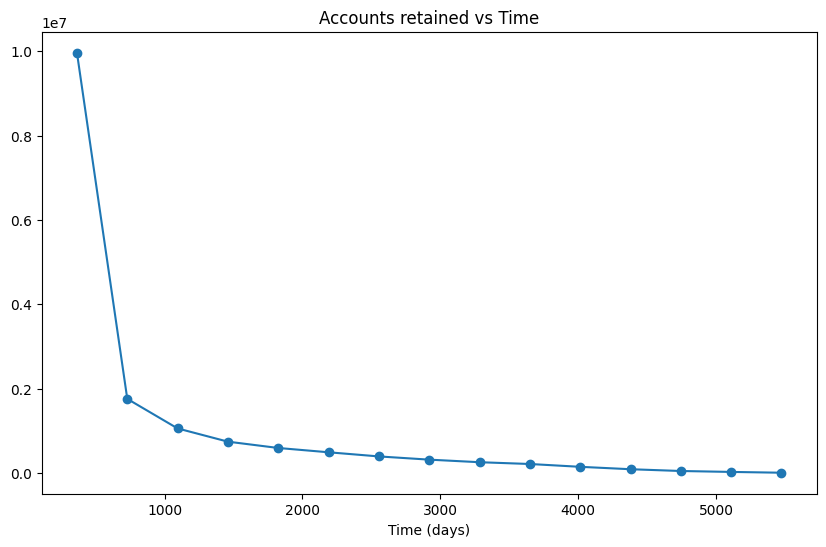

In [22]:
retention_yearly = {
    "1 year": (years < 1).sum(),
    "2 years": ((years >= 1) & (years < 2)).sum(),
    "3 years": ((years >= 2) & (years < 3)).sum(),
    "4 years": ((years >= 3) & (years < 4)).sum(),
    "5 years": ((years >= 4) & (years < 5)).sum(),
    "6 years": ((years >= 5) & (years < 6)).sum(),
    "7 years": ((years >= 6) & (years < 7)).sum(),
    "8 years": ((years >= 7) & (years < 8)).sum(),
    "9 years": ((years >= 8) & (years < 9)).sum(),
    "10 years": ((years >= 9) & (years < 10)).sum(),
    "11 years": ((years >= 10)  & (years < 11)).sum(),
    "12 years": ((years >= 11)  & (years < 12)).sum(),
    "13 years": ((years >= 12)  & (years < 13)).sum(),
    "14 years": ((years >= 13)  & (years < 14)).sum(),
    "15 years": ((years >= 14)  & (years < 15)).sum()
}

x = [i for i in range(365, 5840, 365)]
y = list(retention_yearly.values())

plt.figure(figsize=(10, 6))
plt.plot(x,y, marker='o')
plt.xlabel('Time (days)')
plt.title('Accounts retained vs Time')

plt.show()

As expected from our pie chart this graph shows that the large majority of accounts become inactive within the first year after being created. There is then a significant drop in the number of accounts abandoned in their second year compared to their first. It also shows that the number of accounts being abandoned each year tends toward 0 over time. 

Therefore, we are able to come to the conclusion that the longer a user account remains active the more likely it is to continue to remain active. 

## Task success
The task success metric is defined as:
>Task Success: Measure of user ability to accomplish their goals and tasks effectively on Stack Overflow.

*TODO*
*Metric analysis not yet implemented*